In [5]:
import pickle
import torch, os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

In [7]:
from ipywidgets import IntProgress
from IPython.display import display
import time

progress = IntProgress(min=0, max=100)  # Create progress bar
display(progress)

for i in range(101):
    progress.value = i
    time.sleep(0.1)


IntProgress(value=0)

In [8]:
embed_model = HuggingFaceEmbedding(
                                    model_name="BAAI/bge-small-en-v1.5",
                                    device="cuda:0" if torch.cuda.is_available() else "cpu"
                                    ) #model initialization for embedding text data

In [9]:
def data_pipe(
            data_path = "data/XSS_dataset.csv",
            input_artifact_path = "artifacts/xss.npz",
            ):
    if not os.path.exists(input_artifact_path):
        df = pd.read_csv(data_path)
        df = df.dropna()
        df = df.drop_duplicates()

        inputs = df['Sentence'].values  
        embeddings = embed_model.get_text_embedding_batch(inputs)
        X = np.array(embeddings)
        Y = df['Label'].values

        np.savez(input_artifact_path, X=X, Y=Y)

    data = np.load(input_artifact_path)
    X = data['X']
    Y = data['Y']

    return X, Y


In [13]:
X, Y = data_pipe()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                X, Y, 
                                                test_size=0.2, 
                                                random_state=42
                                                )

print(f"Xtrain shape: {Xtrain.shape}")
print(f"Ytrain shape: {Ytrain.shape}")
print(f"Xtest shape: {Xtest.shape}")
print(f"Ytest shape: {Ytest.shape}")

Xtrain shape: (10948, 384)
Ytrain shape: (10948,)
Xtest shape: (2738, 384)
Ytest shape: (2738,)


In [15]:
rfc = RandomForestClassifier(
                            n_estimators=20,
                            max_depth=12
                            )
rfc.fit(Xtrain, Ytrain)

RandomForestClassifier(max_depth=12, n_estimators=20)

In [17]:
with open('artifacts/xss_model.pickle', 'wb') as f: #save the trained Random Forest model 
    pickle.dump(rfc, f)

In [19]:
Ptrain = rfc.predict(Xtrain) #create predictions 
Ptest = rfc.predict(Xtest)

### evaluation

In [22]:
cls_train = classification_report(
                                Ytrain, 
                                Ptrain,
                                target_names=[
                                            "Normal",
                                            "XSS"
                                            ]
                                )       
cls_test = classification_report(
                                Ytest, 
                                Ptest,
                                target_names=[
                                            "Normal",
                                            "XSS"
                                            ]
                                )   

print("Train Classification Report")
print(cls_train)

print("Test Classification Report")
print(cls_test)

Train Classification Report
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      5053
         XSS       1.00      1.00      1.00      5895

    accuracy                           1.00     10948
   macro avg       1.00      1.00      1.00     10948
weighted avg       1.00      1.00      1.00     10948

Test Classification Report
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00      1260
         XSS       1.00      0.99      1.00      1478

    accuracy                           1.00      2738
   macro avg       1.00      1.00      1.00      2738
weighted avg       1.00      1.00      1.00      2738



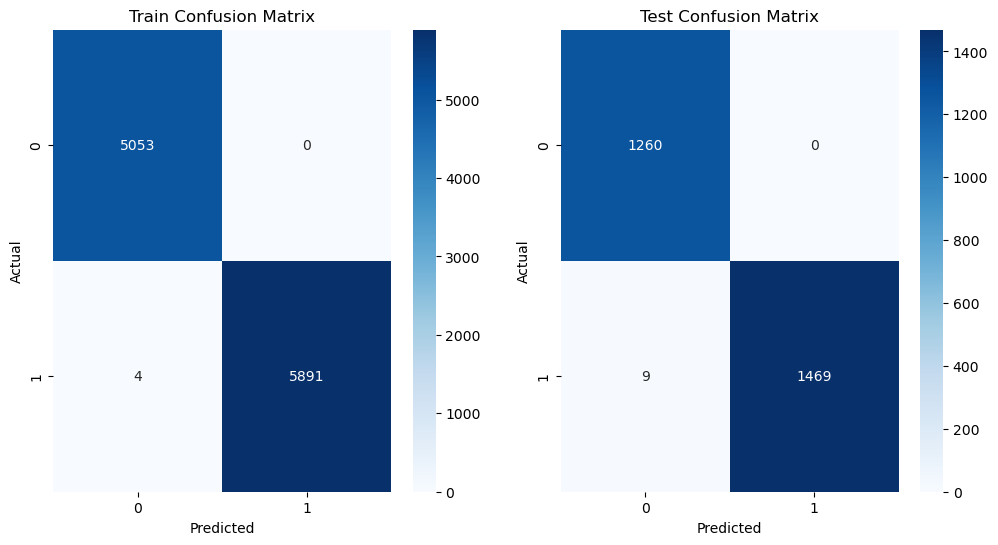

In [24]:
cm_train = confusion_matrix(Ytrain, Ptrain) 
cm_test = confusion_matrix(Ytest, Ptest)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xtricks = ['Normal', 'XSS']
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xtricks = ['Normal', 'XSS']
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

### inference

In [27]:
embed_model = HuggingFaceEmbedding(
                                model_name="BAAI/bge-small-en-v1.5",
                                device="cuda:0" if torch.cuda.is_available() else "cpu"
                                )

with open('artifacts/xss_model.pickle', 'rb') as f:
    rfc = pickle.load(f)

In [29]:
def inference_xss(
                sentence,
                threshold=0.5
                ):
    embedding = embed_model.get_text_embedding(sentence)
    embedding = np.array([embedding])
    prediction = rfc.predict_proba(embedding)
    return "Attack" if prediction[0][1] > threshold else "Normal"

In [53]:
inference_xss(""""
http://example.com/?q=<img src=x:alert(1)>""")

'Attack'